In [1]:
# 라이브러리 import
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
plt.style.use('seaborn')
sns.set(font_scale=2) 

import torch
import torchvision
from PIL import Image

/tmp/ipykernel_528013/1362932981.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/home/iai/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#데이터 읽어오기
df = pd.read_pickle("/home/iai/Desktop/bsh/LSWMD.pkl")

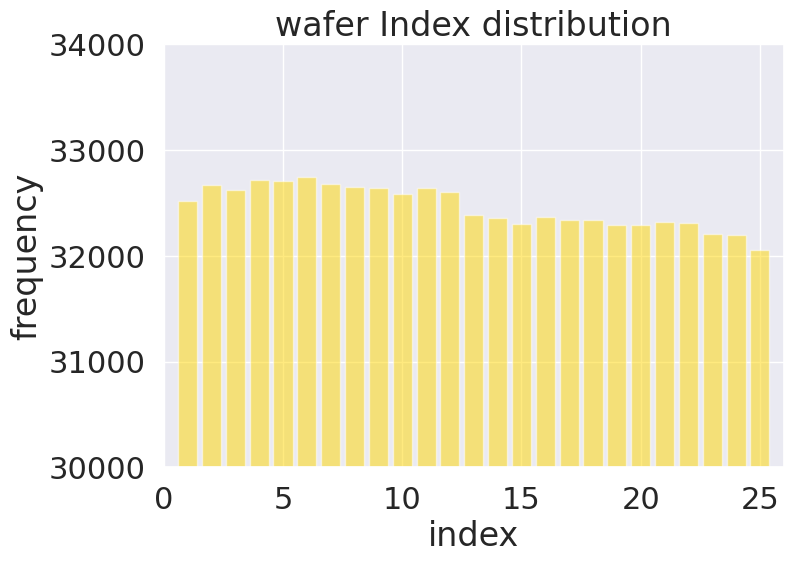

In [3]:
#데이터 분포확인 - 시각화 

uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title("wafer Index distribution")
plt.xlabel("index")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [4]:
# 웨이퍼 인덱스 필요없음
df = df.drop(['waferIndex'], axis = 1)

# + 새로운 변수추가 / 웨이퍼 다이크기 다양함. : waferMapDim(가로,세로) 열생성 
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
343464,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5139.0,lot20583,[],[],"(81, 81)"
700434,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,...",516.0,lot43041,[[Training]],[[none]],"(25, 27)"
336019,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",820.0,lot20254,[],[],"(32, 33)"
83914,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",939.0,lot5983,[],[],"(39, 31)"
162360,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",14116.0,lot10454,[],[],"(212, 84)"


In [5]:
# 고장 유형 및 class dist. 확인
df['failureNum'] = df.failureType
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
df=df.replace({'failureNum': mapping_type})

/home/iai/anaconda3/envs/bsh/lib/python3.8/site-packages/pandas/core/array_algos/replace.py:86: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [6]:
# df_withlabel : labeled wafer
# df_withpattern : labeled & patterned wafer 
# df_nonpatter : labeled but non-patterned wafer

df_withlabel = df[(df['failureType']!=0)]
df_withlabel =df_withlabel.reset_index() #labeled index.
df_withpattern = df_withlabel[(df_withlabel['failureType'] != 'none')]
df_withpattern = df_withpattern.reset_index() #patterned index.
df_nonpattern = df_withlabel[(df_withlabel['failureType'] == 'none')] #nonpatterned index

df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

/home/iai/anaconda3/envs/bsh/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


(172950, 25519, 147431)

([<matplotlib.patches.Wedge at 0x7f2bc4fcf850>,
 [Text(-0.9408961094233836, 0.7447915891522543, 'no label'),
  Text(0.3568914732011969, -1.0404943422990245, 'label & pattern'),
  Text(0.9256244028385539, -0.5943226942240811, 'label & non-pattern')],
 [Text(-0.548856063830307, 0.434461760338815, '78.7%'),
  Text(0.19466807629156194, -0.5675423685267406, '3.1%'),
  Text(0.5048860379119384, -0.32417601503131693, '18.2%')])

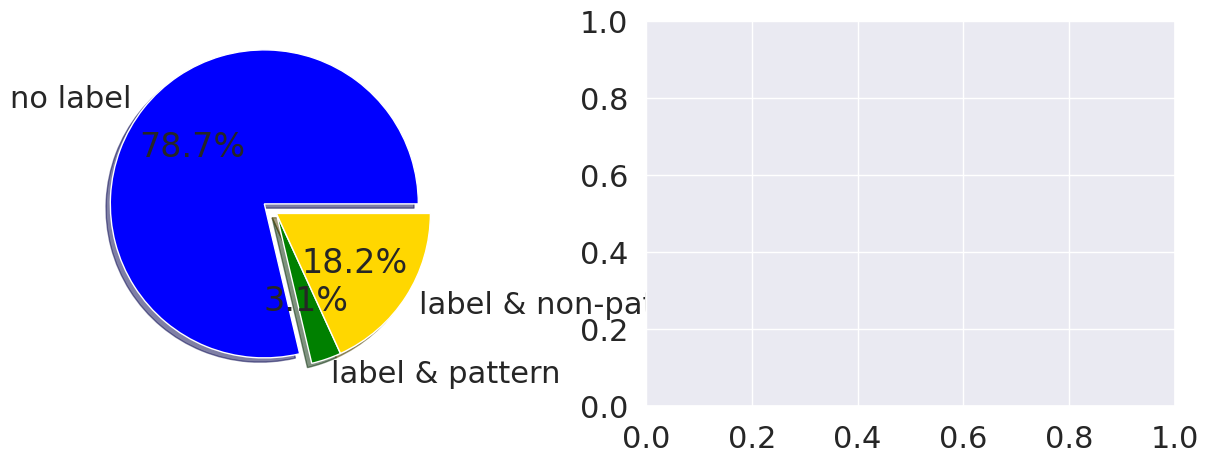

In [7]:
fig,ax = plt.subplots(1,2, figsize = (15,5))
colors = ['blue', 'green', 'gold']
num_wafers=[len(df['waferMap'])-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]
labels = ['no label', 'label & pattern', 'label & non-pattern']
ax[0].pie(num_wafers, explode=(0.1,0,0), labels = labels, colors = colors, autopct = '%1.1f%%', shadow=True)
# sns.countplot('failureNum', data = 'df_withpattern_0' , ax=ax[1])
# ax[1].set_title("failure type frequency")
# ax[1].set_ylabel("number of patterned wafers")
# plt.subplots_adjust(wspace = 1.5)
# plt.show()

#countplot() got multiple values for argument 'data' : df_withpattern 변수가 두개, df_withpatern_0으로 구별했지만 오류.

In [8]:
df_withlabel['waferMapDim'].value_counts() #use two dim (25,27) & (26,26) 상위 2개

(25, 27)     18781
(26, 26)     14366
(30, 34)     12400
(29, 26)     11751
(27, 25)     10682
             ...  
(68, 72)         1
(29, 45)         1
(38, 62)         1
(43, 133)        1
(36, 41)         1
Name: waferMapDim, Length: 346, dtype: int64

In [9]:
#extract (25,27) & (26,26) waferMapDim data
def subwafer(sw,label):
  Dim0 = np.size(sw, axis=1)
  Dim1 = np.size(sw, axis=2)
  sub_df = df_withlabel.loc[df_withlabel['waferMapDim'] == (Dim0, Dim1)]
  sub_wafer = sub_df['waferMap'].values
  sw = sw.to(torch.device('cuda'))                                                      # torch.decvice('cuda') : cuda사용
  for i in range(len(sub_df)):
    waferMap = torch.from_numpy(sub_df.iloc[i,:]['waferMap'].reshape(1, Dim0, Dim1))    # torch.from_numpy : numpy에서 torch로 바꾸기
    waferMap = waferMap.to(torch.device('cuda'))  
    sw = torch.cat([sw, waferMap])                                                      # torch.cat((a, b, c ...), dim = 0 or 1) : a, b, c가 쌓이며 dim 값에 따라 a, b, c가 쌓이는 방향이 달라진다.
    label.append(sub_df.iloc[i,:]['failureType'][0][0])
  x = sw[1:]
  y = np.array(label).reshape((-1,1))
  del waferMap, sw
  return x, y

In [10]:
sw0 = torch.ones((1, 25, 27))           # torch.ones(a, b) :  1 값을 가진 a x b의 tensor 생성
sw1 = torch.ones((1, 26, 26))
label0 = list()
label1 = list()

x0, y0 = subwafer(sw0, label0) 
x1, y1 = subwafer(sw1, label1) 

x0.shape, x1.shape

(torch.Size([18781, 25, 27]), torch.Size([14366, 26, 26]))

In [11]:
# add RGB space for one-hot encoding
# 0: non wafer -> R, 1: normal die -> G, 2: defect die -> B|

def rgb_sw(x):
  Dim0 = np.size(x, axis=1)
  Dim1 = np.size(x, axis=2)
  new_x = np.zeros((len(x), Dim0, Dim1, 3))
  x = torch.unsqueeze(x,-1)                                     # torch.unsqueeze : 1인 차원을 생성
  x = x.to(torch.device('cpu'))
  x = x.numpy()
  for w in range(len(x)): 
      for i in range(Dim0):
          for j in range(Dim1):
              new_x[w, i, j, int(x[w, i, j])] = 1
  return new_x


rgb_x0 = rgb_sw(x0) 
rgb_x1 = rgb_sw(x1)

del x0, x1 


In [12]:
# we have to resize these data.
def resize(x):
  rwm = torch.ones((1,56,56,3))
  for i in range(len(x)):
    rwm = rwm.to(torch.device('cuda'))
    a = Image.fromarray(x[i].astype('uint8')).resize((56,56))
    a = np.array(a).reshape((1,56,56,3))
    a = torch.from_numpy(a)
    a = a.to(torch.device('cuda'))
    rwm = torch.cat([rwm, a])
  x = rwm[1:]
  del rwm
  return x

resized_x0 = resize(rgb_x0)
resized_x1 = resize(rgb_x1)

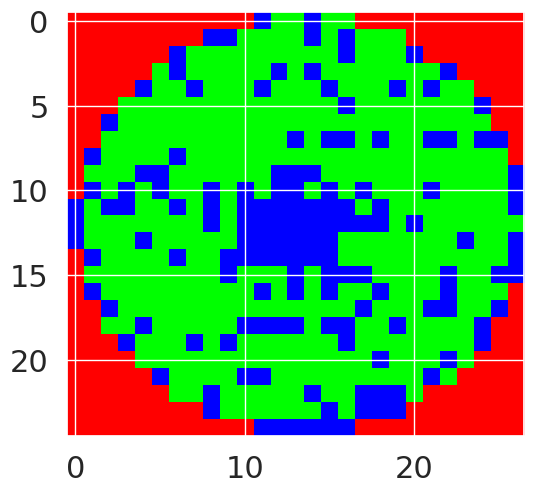

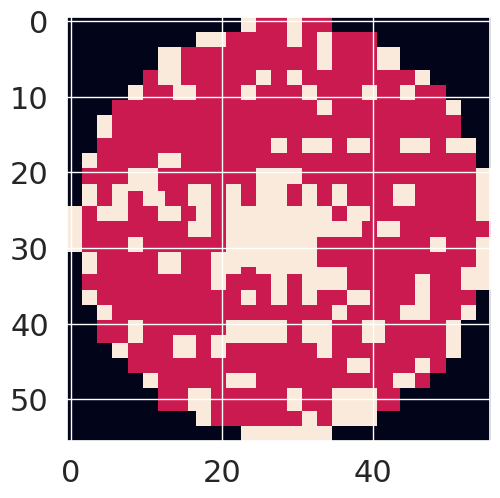

In [13]:
plt.imshow(rgb_x0[1000])
plt.show()
plt.imshow(torch.argmax(resized_x0[1000],axis=2).cpu().numpy())       #torch.argmax(x) : 최댓값의 인덱스를 구한다. 
plt.show()

In [14]:
del rgb_x0, rgb_x1  #delete useless data

resized_wm = torch.cat([resized_x0, resized_x1])
label_wm = np.concatenate((y0,y1)) #concatenate To use all data.
del y0,y1,resized_x0, resized_x1  #delete useless data

In [15]:
# Convolutional Autoencoder 
# parameter
args = {
	'BATCH_SIZE': 16,
        'LEARNING_RATE': 0.001,
        'NUM_EPOCH': 10
        }

resized_wm = resized_wm.permute(0,3,1,2)
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
train_loader  = torch.utils.data.DataLoader(resized_wm, args['BATCH_SIZE'], shuffle=True)

In [16]:
resized_wm.shape, label_wm.shape

(torch.Size([33147, 3, 56, 56]), (33147, 1))

In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

In [18]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # 인코더
        self.cnn_layer1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                         nn.MaxPool2d(2,2))

        self.cnn_layer2 = nn.Sequential(
                                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                 nn.MaxPool2d(2,2))

        # 디코더
        self.tran_cnn_layer1 = nn.Sequential(
                        nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding=0),
                        nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(16, 3, kernel_size = 2, stride = 2, padding=0),
                        nn.Sigmoid())
            
    def encoder(self, x):
        encode = self.cnn_layer1(x)
        encode = self.cnn_layer2(encode)   
        return encode
    
    def decoder(self, x):
        decode = self.tran_cnn_layer1(x)
        decode = self.tran_cnn_layer2(decode)
        return decode

    def forward(self, x):
        output = self.encoder(x)
        output = self.decoder(output)
        return output

In [19]:
model = ConvAutoEncoder().to(DEVICE)
print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])

ConvAutoEncoder(
  (cnn_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tran_cnn_layer1): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (tran_cnn_layer2): Sequential(
    (0): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (1): Sigmoid()
  )
)


In [20]:
steps = 0
print(resized_wm.shape)

total_steps = len(train_loader)
losses =[]
iterations = []
for epoch in range(args['NUM_EPOCH']):    
    running_loss = 0.0
    for i,wafer in enumerate(train_loader):
        steps += 1
        wafer = wafer.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(wafer)
        loss = criterion(outputs, wafer) # autoencoder loss : compare input & output
        loss.backward()
        running_loss += loss.item()*wafer.shape[0]
        optimizer.step()
        if steps % total_steps == 0:
            model.eval()
            print('Epoch: {}/{}'.format(epoch+1, args['NUM_EPOCH']),
                 "=> loss : %.3f"%(running_loss/total_steps))
            steps = 0
            iterations.append(i)
            losses.append(running_loss / total_steps)
            model.train()

del wafer, optimizer, loss

torch.Size([33147, 3, 56, 56])
Epoch: 1/10 => loss : 0.505
Epoch: 2/10 => loss : 0.148
Epoch: 3/10 => loss : 0.104
Epoch: 4/10 => loss : 0.085
Epoch: 5/10 => loss : 0.073
Epoch: 6/10 => loss : 0.066
Epoch: 7/10 => loss : 0.060
Epoch: 8/10 => loss : 0.056
Epoch: 9/10 => loss : 0.053
Epoch: 10/10 => loss : 0.050


In [21]:
faulty_case = np.unique(label_wm)
print(faulty_case)

['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [22]:
#데이터 증강

import torch.nn.init

def gen_data(wafer, label):
  gen_x = torch.zeros((1, 3, 56, 56))
  with torch.no_grad():
    encoded_x = model.encoder(wafer).to(torch.device('cpu'))
    # dummy array for collecting noised wafer 
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
      noised_encoded_x = (encoded_x + torch.from_numpy(np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 32, 14, 14))).to(torch.device('cpu'))).to(DEVICE)
      noised_decoded_x = model.decoder(noised_encoded_x.float()).to(torch.device('cpu'))
      gen_x = torch.cat([gen_x, noised_decoded_x], axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    # return date without 1st dummy data.
  del encoded_x, noised_encoded_x, noised_decoded_x
  return gen_x[1:], gen_y[1:]

In [23]:
# 모든 faulty 데이터를 증강
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    gen_x, gen_y = gen_data(resized_wm[np.where(label_wm==f)[0]].to(DEVICE), f)
    resized_wm = torch.cat([resized_wm.to(torch.device('cpu')), gen_x], axis=0)
    label_wm = np.concatenate((label_wm, gen_y))

print('After Generate resized_wm shape : {}, label_wm shape : {}'.format(resized_wm.shape, label_wm.shape))
del gen_x, gen_y

After Generate resized_wm shape : torch.Size([50611, 3, 56, 56]), label_wm shape : (50611, 1)


In [24]:
none_idx = np.where(label_wm=='none')[0][np.random.choice(len(np.where(label_wm=='none')[0]), size=27150, replace=False)]
EdgeLoc_idx = np.where(label_wm=='Edge-Loc')[0][np.random.choice(len(np.where(label_wm=='Edge-Loc')[0]), size=1100, replace=False)]
Center_idx = np.where(label_wm=='Center')[0][np.random.choice(len(np.where(label_wm=='Center')[0]), size=2500, replace=False)]
Loc_idx = np.where(label_wm=='Loc')[0][np.random.choice(len(np.where(label_wm=='Loc')[0]), size=600, replace=False)]
delete_idx = np.concatenate((none_idx, EdgeLoc_idx, Center_idx, Loc_idx))
delete_idx.shape

(31350,)

In [25]:
resized_wm.shape

torch.Size([50611, 3, 56, 56])

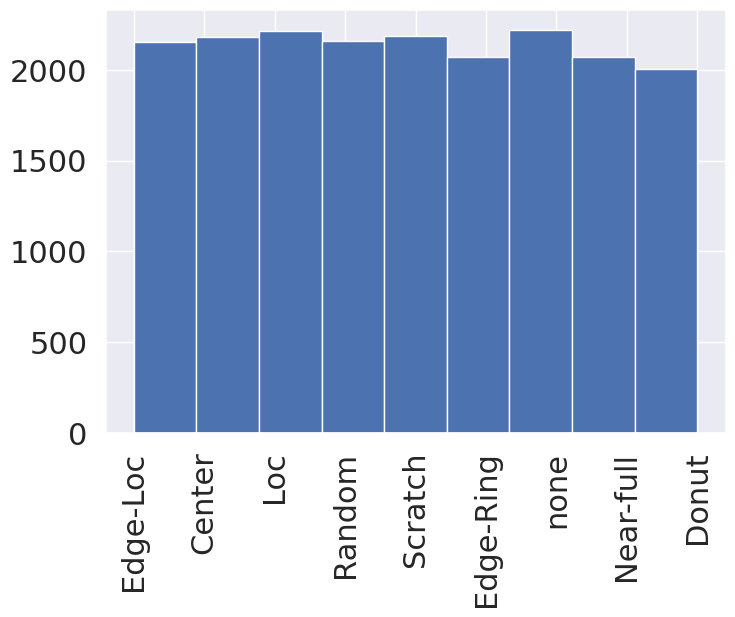

In [26]:
remove_wm = np.delete(resized_wm.detach().cpu().numpy(), delete_idx, axis=0)
resized_wm = torch.from_numpy(remove_wm)
del_idx = np.concatenate((none_idx, EdgeLoc_idx, Center_idx, Loc_idx))
label_wm = np.delete(label_wm, del_idx, axis=0)

n, bins, patches = plt.hist(label_wm, bins=9)
plt.xticks(rotation=90)
plt.show()

In [27]:
# one-hot-encoding
for i, l in enumerate(faulty_case):
    label_wm[label_wm==l] = i    
    print('i : {}, l : {}'.format(i, l))
    
def _to_one_hot(y, num_classes):
    scatter_dim = len(y.size())
    y_tensor = y.view(*y.size(), -1)
    zeros = torch.zeros(*y.size(), num_classes, dtype=y.dtype)
    return zeros.scatter(scatter_dim, y_tensor, 1)

label_wm = _to_one_hot(torch.as_tensor(np.int64(label_wm)), num_classes=9)

i : 0, l : Center
i : 1, l : Donut
i : 2, l : Edge-Loc
i : 3, l : Edge-Ring
i : 4, l : Loc
i : 5, l : Near-full
i : 6, l : Random
i : 7, l : Scratch
i : 8, l : none


In [28]:
import torch.utils.data as data

class BasicDataset(data.Dataset):
    def __init__(self, x_tensor, y_tensor):
        super(BasicDataset, self).__init__()

        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

from sklearn import model_selection
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(resized_wm, label_wm , test_size=0.2)
dataset_train = BasicDataset(train_X,train_Y)
dataset_test = BasicDataset(test_X, test_Y)
dataset = ConcatDataset([dataset_train, dataset_test])

In [29]:
#CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob1 = 0.2
        self.keep_prob2 = 0.5

        self.layer1 =nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), #1번째 conv layer : 입력 층 3, 출력 32, Relu, Poolling으로 MAX 직용.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

    
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), #2번째 conv layer : 입력 층 32, 출력 64, Relu, Poolling으로 MAX 직용.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), #3번째 conv layer : 입력 층 64, 출력 128, Relu, Polling으로 Max 적용.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        self.fc1 = nn.Linear(8 * 8 * 128, 1250, bias=True) # fully connected, 
        nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = nn.Sequential(
            self.fc1,
            nn.ReLU()) #dropout 적용

        self.fc2 = nn.Linear(1250, 9, bias=True) #오류패턴 9개로 출력 9
        nn.init.xavier_uniform_(self.fc2.weight)
        

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # fully conntect를위해 flatten을 함.
        out = self.layer4(out)
        out = self.fc2(out)
        return out
CNN = CNN().to(DEVICE)
print(CNN)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=8192, out_features=1250, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=8192, out_features=1250, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=1250, out_features=9, bias=True)
)


In [30]:
args = {
	'BATCH_SIZE': 256,
        'LEARNING_RATE': 0.005,
        'NUM_EPOCH': 10
        }

In [31]:
criterion = torch.nn.CrossEntropyLoss().to(DEVICE) # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(CNN.parameters(), lr=args['LEARNING_RATE'])
torch.manual_seed(42)
splits = KFold(n_splits=5, shuffle = True, random_state = 42)
foldperf={}

In [32]:
def train_epoch(model, dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE).reshape(args['BATCH_SIZE'], 9)
        optimizer.zero_grad()
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        train_correct += (predictions == labels).sum().item()
    print(train_correct)
    return train_loss,train_correct
  
def valid_epoch(model,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE).reshape(args['BATCH_SIZE'],9)
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        val_correct+=(predictions == labels).sum().item()
    return valid_loss,val_correct
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=args['BATCH_SIZE'], sampler=train_sampler, drop_last=True)
    test_loader = DataLoader(dataset, batch_size=args['BATCH_SIZE'], sampler=test_sampler, drop_last=True)
    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(args['NUM_EPOCH']):
        train_loss, train_correct=train_epoch(CNN,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(CNN,test_loader,criterion)
        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             args['NUM_EPOCH'],
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  
  

Fold 1
9912
Epoch:1/10 AVG Training Loss:1.222 AVG Test Loss:0.342 AVG Training Acc 64.33 % AVG Test Acc 86.50 %
13704
Epoch:2/10 AVG Training Loss:0.302 AVG Test Loss:0.236 AVG Training Acc 88.94 % AVG Test Acc 91.02 %
13470
Epoch:3/10 AVG Training Loss:0.412 AVG Test Loss:0.205 AVG Training Acc 87.42 % AVG Test Acc 92.86 %
14550
Epoch:4/10 AVG Training Loss:0.175 AVG Test Loss:0.122 AVG Training Acc 94.43 % AVG Test Acc 95.35 %
15064
Epoch:5/10 AVG Training Loss:0.069 AVG Test Loss:0.057 AVG Training Acc 97.77 % AVG Test Acc 98.21 %
15199
Epoch:6/10 AVG Training Loss:0.039 AVG Test Loss:0.048 AVG Training Acc 98.64 % AVG Test Acc 98.31 %
15265
Epoch:7/10 AVG Training Loss:0.023 AVG Test Loss:0.046 AVG Training Acc 99.07 % AVG Test Acc 98.13 %
15302
Epoch:8/10 AVG Training Loss:0.017 AVG Test Loss:0.055 AVG Training Acc 99.31 % AVG Test Acc 98.39 %
15120
Epoch:9/10 AVG Training Loss:0.060 AVG Test Loss:0.079 AVG Training Acc 98.13 % AVG Test Acc 97.46 %
15275
Epoch:10/10 AVG Training 

In [33]:
#k-fold 교차검증
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=5
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))    #tl_f : train_loss
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))  #testl_f : test_loss

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))      #ta_f : train_정확도
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))    #testa_f : test_정확도

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))   

Performance of 5 fold cross validation
Average Training Loss: 0.053 	 Average Test Loss: 0.032 	 Average Training Acc: 98.13 	 Average Test Acc: 98.62


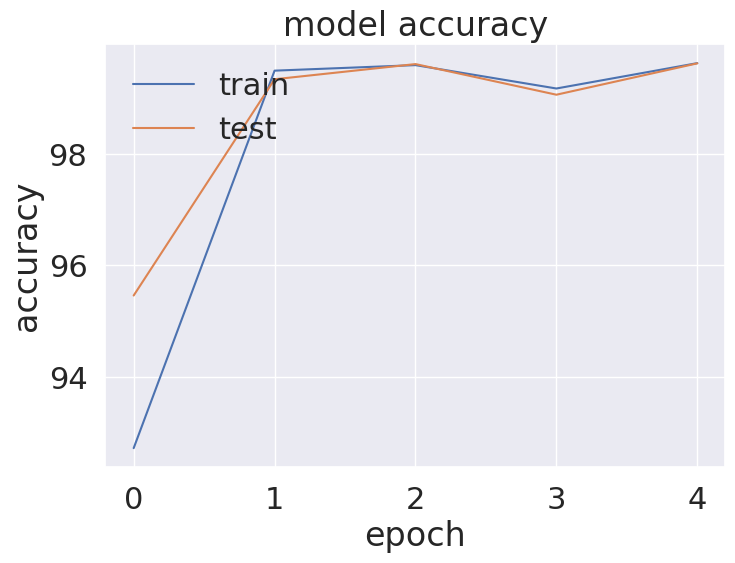

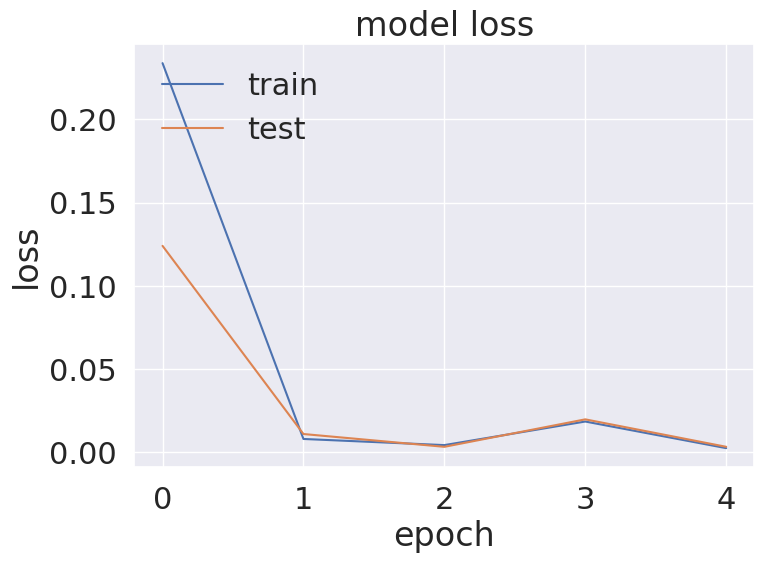

In [34]:
# accuracy plot 
plt.plot(ta_f)
plt.plot(testa_f)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(tl_f)
plt.plot(testl_f)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()